In [2]:
import pandas as pd
import numpy as np
import sklearn.metrics as m
from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
input_path = "../data/features_encoded.csv"
raw_data = pd.read_csv(input_path, header=0, skiprows=None, index_col=None, delimiter=",")

labels = raw_data['malicious'].apply(lambda x: 1 if x else 0)
features = raw_data.drop('malicious', axis=1)

train_features = features.iloc[:80000, :]
test_features = features.iloc[80000:, :]
train_labels = labels[:80000]
test_labels = labels[80000:]

In [4]:
def calculateNormalizationParams(data):
    means = data.mean()
    stdevs = data.std()
    stdevs[stdevs == 0] = 1  # Replace 0 std to avoid division by zero
    return means, stdevs

def applyNormalization(data, means, stdevs):
    return (data - means) / stdevs

In [5]:
means, stdevs = calculateNormalizationParams(train_features)
normalizedTrainFeatures = applyNormalization(train_features, means, stdevs)
normalizedTestFeatures = applyNormalization(test_features, means, stdevs)

In [6]:
# Apply DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=5)  # eps and min_samples can be tuned
dbscan.fit(normalizedTrainFeatures)

DBSCAN(eps=2.0)

In [7]:
# Labels assigned by DBSCAN
train_cluster_labels = dbscan.labels_
test_cluster_labels = dbscan.fit_predict(normalizedTestFeatures)

In [8]:
# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(train_cluster_labels)) - (1 if -1 in train_cluster_labels else 0)
n_noise_ = list(train_cluster_labels).count(-1)

In [9]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 26
Estimated number of noise points: 426


In [10]:
predictions = test_cluster_labels
homogeneity = m.homogeneity_score(test_labels,predictions)
completeness = m.completeness_score(test_labels,predictions)
v_measure = m.v_measure_score(test_labels,predictions)
print("Homogeneity score: " + str(homogeneity))
print("Completeness score: " + str(completeness))
print("V-Measure score: " + str(v_measure))

Homogeneity score: 0.005053151355529705
Completeness score: 0.004951397555232225
V-Measure score: 0.005001756998973519


In [11]:
pred2label = {}
for i in range(0,len(predictions)):
    if not str(predictions[i]) in pred2label:
        pred2label.update({str(predictions[i]):{str(test_labels.iloc[i]):1}})
    elif not str(test_labels.iloc[i]) in pred2label[str(predictions[i])]:
        pred2label[str(predictions[i])].update({str(test_labels.iloc[i]):1})
    else:
        cur = int(pred2label[str(predictions[i])][str(test_labels.iloc[i])])
        pred2label[str(predictions[i])][str(test_labels.iloc[i])] = str(cur + 1)
for cluster in pred2label:
    bcount = int(pred2label[cluster]["0"]) if "0" in pred2label[cluster] else 0
    mcount = int(pred2label[cluster]["1"]) if "1" in pred2label[cluster] else 0
    if bcount > mcount:
        pred2label[cluster]["label"] = 0
        pred2label[cluster]["probability"] = float(bcount)/float(bcount+mcount)
    else:
        pred2label[cluster]["label"] = 1
        pred2label[cluster]["probability"] = float(mcount)/float(bcount+mcount)

In [12]:
def getLabel(x):
    return pred2label[str(x)]["label"]
predictions = [getLabel(x) for x in predictions]
def getProb(x):
    return pred2label[str(x)]["probability"]
probs = [getProb(x) for x in predictions]

In [13]:
acc = m.accuracy_score(test_labels, predictions)
prec = m.precision_score(test_labels, predictions)
recall = m.recall_score(test_labels, predictions)
f1 = m.f1_score(test_labels,predictions)
auc = m.roc_auc_score(test_labels,probs)
print("Accuracy score: " + str(acc))
print("Precision score: " + str(prec))
print("Recall score: " + str(recall))
print("F1 score: ", f1)
print("AUC-ROC: ", auc)

Accuracy score: 0.6009699515024248
Precision score: 1.0
Recall score: 0.0016262196647485615
F1 score:  0.0032471587361059076
AUC-ROC:  0.49918689016762574


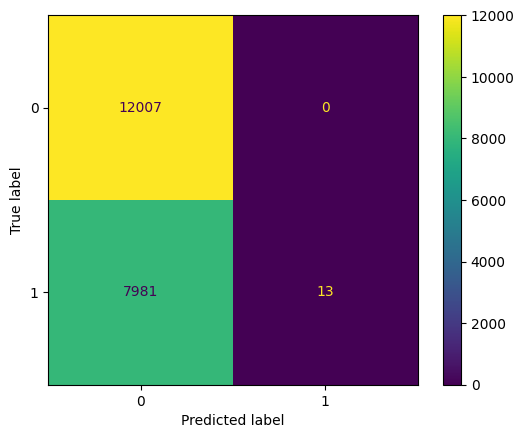

In [14]:
m.ConfusionMatrixDisplay(m.confusion_matrix(test_labels, predictions)).plot()

In [16]:
import pickle
with open('trained_models/dbscan.pkl','wb') as f:
    pickle.dump(dbscan,f)
print("Model dump complete!")

Model dump complete!
